In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt; plt.rc('font', size=16)
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
from pathlib import Path

In [2]:
# Define useful lookup variables
cols = ['#016bff',
        '#b91f1c',
        '#308937',
        '#ff8137',
        '#6f4fc7',
        '#d4b300',
        '#893a2b',
        '#ff6c79',
        '#16c4ff',
        '#766f41',
        '#00c800',
        '#af3261']

pretty_names_dir = {'B_caccae': '$B. caccae$',
                'B_cellulosilyticus_WH2': '$B. cellulosilyticus$',
                'B_ovatus': '$B. ovatus$',
                'B_thetaiotaomicron': '$B. thetaiotaomicron$',
                'B_uniformis': '$B. uniformis$',
                'B_vulgatus': '$B. vulgatus$',
                'C_aerofaciens': '$C. aerofaciens$',
                'C_scindens': '$C. scindens$',
                'C_spiroforme': '$C. spiroforme$',
                'D_longicatena': '$D. longicatena$',
                'P_distasonis': '$P. distasonis$',
                'R_obeum': '$R. obeum$'}

In [3]:
# Define functions
def parse_df(df):
    # Get the mean abundance per species
    df_mean = df.copy()
    df_mean = df_mean.groupby(['name', 'Day']).mean().reset_index()
    df_mean.set_index('name', inplace=True)
    df_mean.drop(columns=['Mouse'], inplace=True)
    df_mean = df_mean.pivot_table(index='Day', columns=df_mean.index, values='Absolute_abundance')
    df_mean.columns.name = None
    df_mean = df_mean.loc[:,df_mean.mean(axis=0).sort_values(ascending=False).index]
    # Get the standard deviation of the abundance per species
    df_std = df.copy()
    df_std = df.groupby(['name', 'Day']).std().reset_index()
    df_std.set_index('name', inplace=True)
    df_std.drop(columns=['Mouse'], inplace=True)
    df_std = df_std.pivot_table(index='Day', columns=df_std.index, values='Absolute_abundance')
    df_std.columns.name = None
    df_std = df_std.loc[:,df_mean.mean(axis=0).sort_values(ascending=False).index]
    return df_mean, df_std

def plot_abundance_bar(df, complete_days=False, logy=False, pretty_names=True, std=True, legend=True, figsize=(10, 7), ax=None, save_f=None):
    # Pretty names
    if pretty_names:
        df['name'] = df['name'].replace(pretty_names_dir)
    df_mean, df_std = parse_df(df)
    if complete_days:
        for day in np.arange(0, 40+1):
            if day not in df_mean.index:
                df_mean.loc[day] = 0
                df_std.loc[day] = 0
        df_mean.sort_index(inplace=True)
        df_std.sort_index(inplace=True)
    # If std is False, set it to None
    if not std:
        df_std = None
    # Get the index of the days to fill
    fill_indx = [plot_indx for plot_indx, df_indx in enumerate(df_mean.index) if df_indx in np.arange(14, 26+1)]
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
    df_mean.plot.bar(stacked=True, 
        figsize=figsize, 
        width=0.9, 
        color=cols, 
        rot=0, 
        edgecolor='white', 
        linewidth=0.3,
        ax=ax,
        logy=logy,
        yerr=df_std,
        error_kw={'elinewidth': 1, 'capsize': 3, 'capthick': 1},
        legend=legend)
    ax.fill_between(x=fill_indx, y1=0, y2=1e10, color='grey', alpha=0.2)
    if legend:
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax.set_xlabel('Day')
    if complete_days:
        ax.set_xticks(np.arange(0, 40+1, 2))
    if logy:
        ax.set_yscale('log')
        ax.set_ylabel('Log$_{10}$ absolute abundance')
        ax.set_ylim(1, 1e9)
    else:
        ax.set_ylabel('Absolute abundance')
        ax.set_ylim(1, 7.3e8)
    if save_f is not None:
        fig.savefig(f'{save_f}', bbox_inches='tight')
    return fig, ax

def plot_abundance_line(df, logy=False, pretty_names=True, points=True, std=False, legend=True, figsize=(10, 7), ax=None, save_f=None):
    # Pretty names
    if pretty_names:
        df['name'] = df['name'].replace(pretty_names_dir)
    df_mean, df_std = parse_df(df)
    # If std is False, set it to None
    if not std:
        df_std = None
    # Get the index of the days to fill
    fill_indx = [14,26]
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
    df_mean.plot.line(figsize=figsize, 
        color=cols, 
        rot=0, 
        ylim=(0, 4.8e8),
        ax=ax,
        legend=legend)
    if points:
        col = 0
        for i in df_mean.mean(axis=0).sort_values(ascending=False).index:
            x_df = {}
            y_df = {}
            x_df[i] = df[df.name == i].Day.values
            y_df[i] = df[df.name == i].Absolute_abundance.values
            ax.scatter(x_df[i], y_df[i], s=25, color=cols[col])
            if std:
                x_df_mean = {}
                y_df_mean = {}
                y_df_std = {}
                x_df_mean[i] = df_mean.index.values
                y_df_mean[i] = df_mean.loc[:,i].values
                y_df_std[i] = df_std.loc[:,i].values
                plt.errorbar(x_df_mean[i], y_df_mean[i], y_df_std[i], color='k', linestyle='None', elinewidth=1, capsize=2)
            col += 1
    ax.fill_between(x=fill_indx, y1=0, y2=1e10, color='grey', alpha=0.2)
    if legend:
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax.set_xlabel('Day')
    if logy:
        ax.set_yscale('log')
        ax.set_ylabel('Log$_{10}$ absolute abundance')
        ax.set_ylim(1, 1e9)
    else:
        ax.set_ylabel('Absolute abundance')
        ax.set_ylim(1, 3.7e8)
    if save_f is not None:
        fig.savefig(f'{save_f}', bbox_inches='tight')
    return fig, ax

def plot_abundance_area(df, logy=False, pretty_names=False, std=True, legend=True, figsize=(10, 7), ax=None, save_f=None):
    # Pretty names
    if pretty_names:
        df['name'] = df['name'].replace(pretty_names_dir)
    df_mean, df_std = parse_df(df)
    if not std:
        df_std = None
    # Get the index of the days to fill
    fill_indx = [14,26]
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
    df_mean.plot.area(stacked=True, 
        figsize=figsize, 
        color=cols, 
        rot=0, 
        linewidth=0.3,
        ylim=(0, 7.3e8),
        ax=ax,
        legend=legend)
    if std:
        df_mean_stacked = []
        for i in range(len(df_mean.columns)):
            df_mean_stacked.append(plt.gca().get_lines()[i].get_ydata())
        df_mean_stacked = np.array(df_mean_stacked)
        df_mean_stacked = df_mean_stacked.T
        df_mean_stacked = pd.DataFrame(df_mean_stacked, columns=df_mean.columns, index=df_mean.index)
        for i in df_mean.mean(axis=0).sort_values(ascending=False).index:
            x_df_mean = {}
            y_df_mean = {}
            y_df_std = {}
            x_df_mean[i] = df_mean_stacked.index.values
            y_df_mean[i] = df_mean_stacked.loc[:,i].values
            y_df_std[i] = df_std.loc[:,i].values
            plt.errorbar(x_df_mean[i], y_df_mean[i], y_df_std[i], color='k', linestyle='None', elinewidth=1, capsize=2)
    ax.fill_between(x=fill_indx, y1=0, y2=1e10, color='grey', alpha=0.2)
    if legend:
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=12)
    ax.set_xlabel('Day')
    if logy:
        ax.set_yscale('log')
        ax.set_ylabel('Log$_{10}$ absolute abundance')
        ax.set_ylim(1, 1e9)
    else:
        ax.set_ylabel('Absolute abundance')
        ax.set_ylim(1, 7.3e8)
    if save_f is not None:
        fig.savefig(f'{save_f}', bbox_inches='tight')
    return fig, ax

In [4]:
# Datasets
dataset = ['LF0', 'HF0']
# Define the input directory
input_dir = Path(f'mcnulty-datasets/{dataset[0]}') , Path(f'mcnulty-datasets/{dataset[1]}')
# Load the abundance tables
LF0 = pd.read_table(input_dir[0] / 'abs_abundances_per_species.tsv')
HF0 = pd.read_table(input_dir[1] / 'abs_abundances_per_species.tsv')

# LF/HPP ==> HF/HS ==> LF/HPP

In [5]:
LF0

,name,Mouse,Day,Absolute_abundance
0,B_caccae,1,0,5.944503e+06
1,B_cellulosilyticus_WH2,1,0,5.136760e+06
2,B_ovatus,1,0,6.858965e+06
3,B_thetaiotaomicron,1,0,2.720123e+06
4,B_uniformis,1,0,8.943722e+05
...,...,...,...,...
2011,C_scindens,7,40,8.435912e+06
2012,C_spiroforme,7,40,9.231028e+05
2013,D_longicatena,7,40,2.479115e+05
2014,P_distasonis,7,40,3.710654e+07


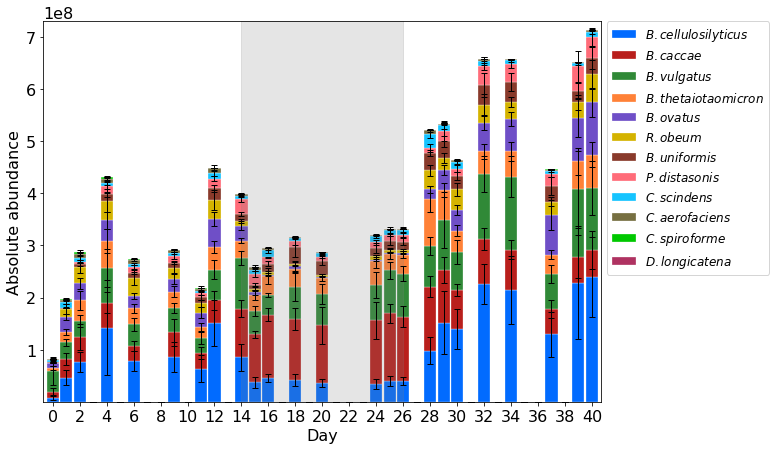

In [6]:
plot_abundance_bar(LF0, complete_days=True)
plt.show()

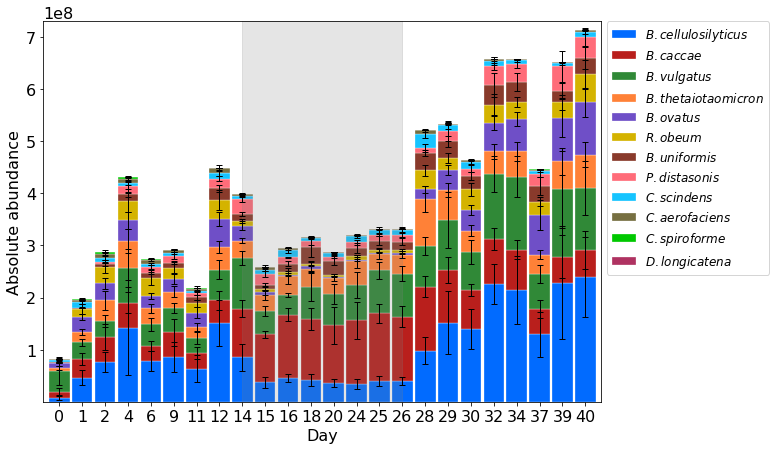

In [7]:
plot_abundance_bar(LF0)
plt.show()

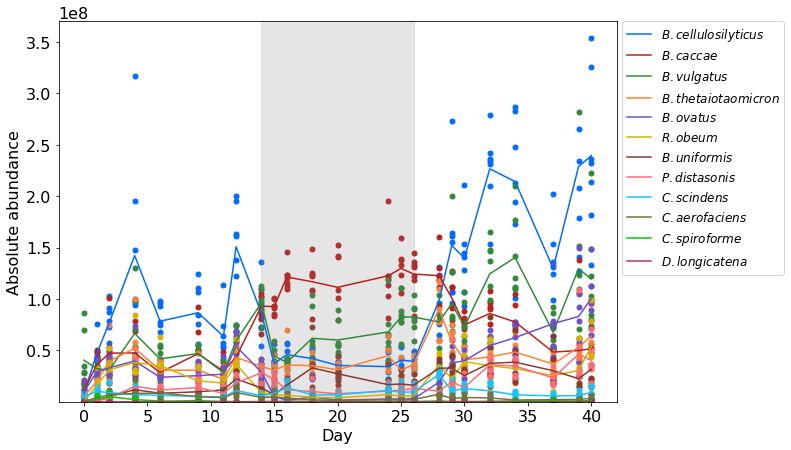

In [8]:
plot_abundance_line(LF0)
plt.show()

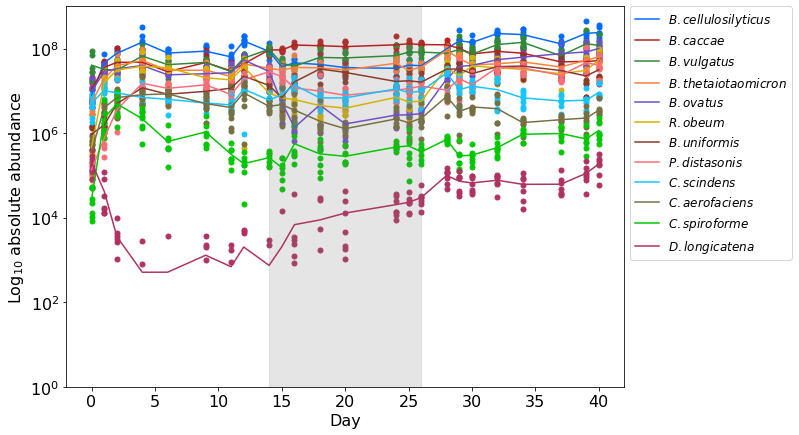

In [9]:
plot_abundance_line(LF0, logy=True)
plt.show()

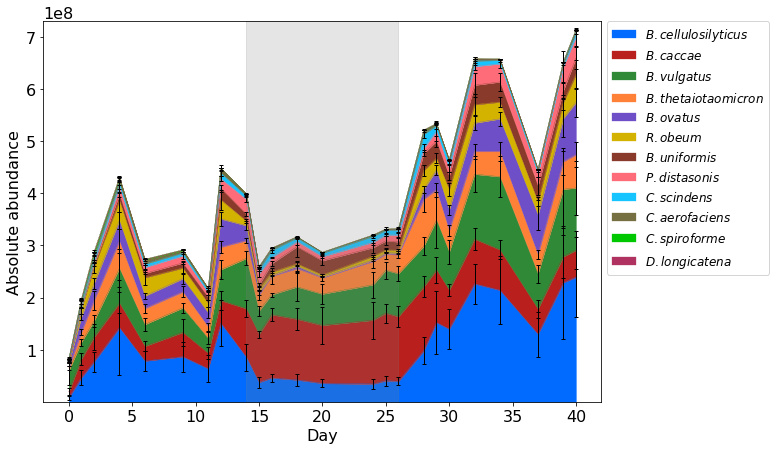

In [10]:
plot_abundance_area(LF0)
plt.show()

# HF/HS ==> LF/HPP ==> HF/HS

In [11]:
HF0

,name,Mouse,Day,Absolute_abundance
0,B_caccae,8,0,2.925774e+07
1,B_cellulosilyticus_WH2,8,0,2.338558e+07
2,B_ovatus,8,0,3.287527e+07
3,B_thetaiotaomicron,8,0,7.832416e+06
4,B_uniformis,8,0,8.163227e+05
...,...,...,...,...
2287,C_scindens,15,40,6.631469e+06
2288,C_spiroforme,15,40,4.275042e+05
2289,D_longicatena,15,40,8.834934e+03
2290,P_distasonis,15,40,4.970340e+06


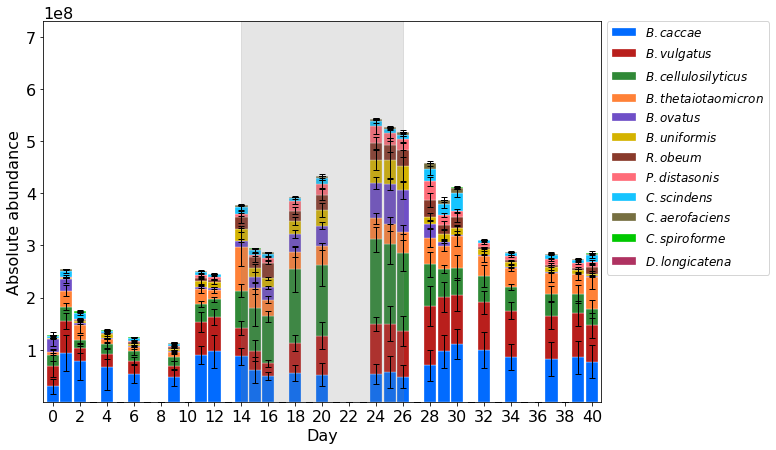

In [12]:
plot_abundance_bar(HF0, complete_days=True)
plt.show()

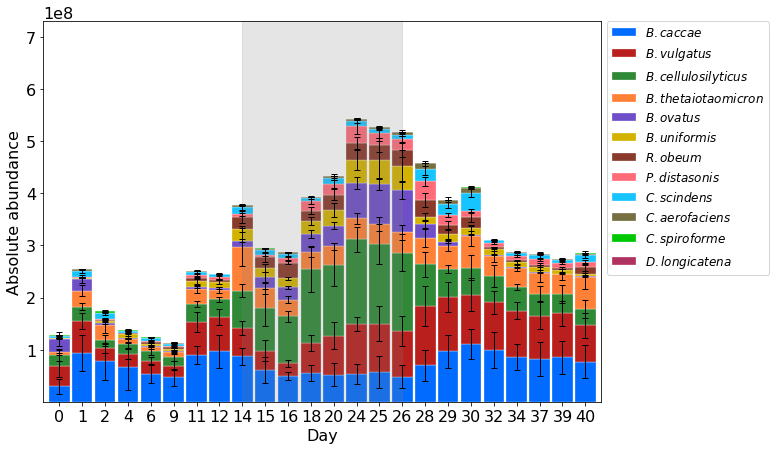

In [13]:
plot_abundance_bar(HF0)
plt.show()

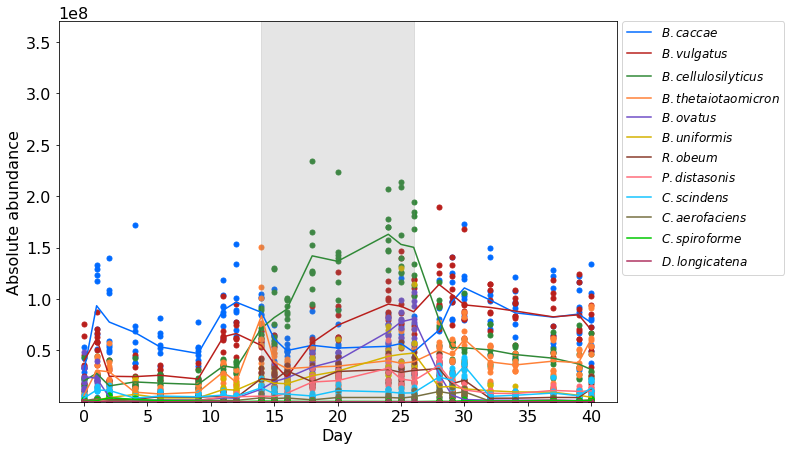

In [14]:
plot_abundance_line(HF0)
plt.show()

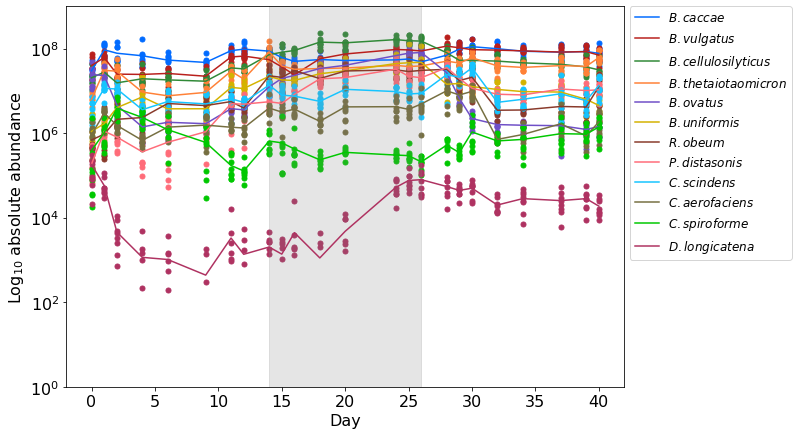

In [15]:
plot_abundance_line(HF0, logy=True)
plt.show()

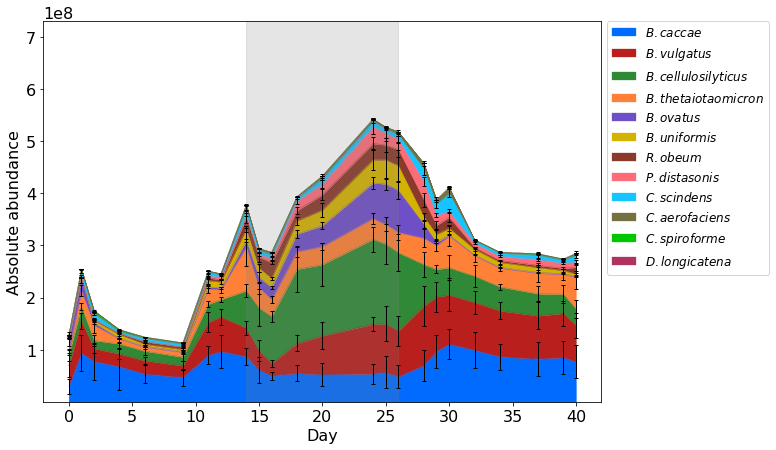

In [16]:
plot_abundance_area(HF0)
plt.show()